In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import time
import datetime as dt

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### READ IN CANARY DATA

In [12]:
canary_log = pq.read_table('../data/CANARY/CANARY/ACTIVITY_LOG').to_pandas()
canary_ps  = pq.read_table('../data/CANARY/CANARY/PERSON_SUMMARY').to_pandas()
canary_ps['TREATED'] = 1

### READ PMPM DATA IN APPROPRIATE FORMAT

In [59]:
pmpm = pd.read_pickle('../temp/controls.p')
pmpm['TREATED'] = 0
pmpm['PERS_ID'] = pmpm.PERS_ID.astype(str)

In [60]:
inter = np.intersect1d(pmpm.columns, canary_ps.columns)

canary_ps = pd.concat((canary_ps[inter], pmpm), axis = 0, ignore_index = True)

In [66]:
canary_ps.drop_duplicates(subset = 'PERS_ID', ignore_index = True, inplace = True)

In [68]:
canary_ps.shape

(641759, 4)

In [70]:
canary_ps.PERS_ID.unique().shape

(641759,)

In [71]:
biometric.PERS_ID.unique().shape

(410095,)

### READ IN BIOMETRIC DATA

In [62]:
biometric = pq.read_table('../data/BIOMETRICS').to_pandas()

In [63]:
biometric.drop(labels = ['DATE_TYPE', 'EVENT_CODE', 'CODING_STANDARD', 'SOURCE'], axis = 1, inplace = True)

### Merge Canary and Biometrics

In [72]:
merged = biometric.merge(canary_ps, on = 'PERS_ID', how = 'inner')

In [73]:
merged.shape

(51215286, 7)

### Ensure dates are in the same Datetime Date format

In [74]:
merged['EVENT_DATE'] = pd.to_datetime(merged.EVENT_DATE).dt.date

In [75]:
merged.head()

PERS_ID  EVENT_DATE BIOMETRIC_CATEGORY        RESULT_VALUE LAST_ACTIVITY_DATE REGISTER_DATE  TREATED
0  2570719  2019-10-02                BMI  25.537491894749788         2020-09-01    2018-11-01        0
1  2570719  2019-01-07          Potassium   5.099999904632568         2020-09-01    2018-11-01        0
2  2570719  2018-12-08             Height    70.0000390014801         2020-09-01    2018-11-01        0
3  2570719  2018-12-11             Height    70.0000390014801         2020-09-01    2018-11-01        0
4  2570719  2018-12-04                BMI  26.398623434221204         2020-09-01    2018-11-01        0

### Filter Data by category

In [76]:
cat_filt = merged.BIOMETRIC_CATEGORY == 'BMI'
merged_cat = merged[cat_filt]

In [78]:
merged_cat.shape

(8756691, 7)

In [87]:
del merged


NameError: name 'merged' is not defined

In [88]:
del pmpm

### Drop Duplicate Ids, Event Dates

In [79]:
merged_drop = merged_cat.drop_duplicates(subset = ['PERS_ID', 'EVENT_DATE'])

In [80]:
def cat_dates(group):
    min_date = group['EVENT_DATE'].min()
    max_date = group['EVENT_DATE'].max()
    total_CAT = len(group['EVENT_DATE'])
    missing = ((max_date - min_date).days // 30) - total_CAT +1
    span    = total_CAT + missing
    reg_date = group.REGISTER_DATE[0]
    timedelta = dt.timedelta(days = 8*30)
    check_from = reg_date - timedelta
    
    return pd.DataFrame([[reg_date, check_from, min_date, max_date, total_CAT, missing, span]], columns = ['REGISTER_DATE', 'CHECK_FROM','MIN_DATE_BMI', 'MAX_DATE_BMI', 'TOTAL_MEAS', 'MISSING', 'SPAN'])

### Sort by PERSON IDS and EVENT DATES

In [81]:
merged_drop = merged_drop.sort_values(by = ['PERS_ID', 'EVENT_DATE']).reset_index(drop = True)

In [82]:
events = merged_drop.groupby('PERS_ID',squeeze = True).apply(cat_dates)
events.index = events.index.droplevel(1)

In [83]:
events

REGISTER_DATE  CHECK_FROM MIN_DATE_BMI MAX_DATE_BMI  TOTAL_MEAS  MISSING  SPAN
PERS_ID                                                                               
2561296    2019-07-01  2018-11-03   2018-07-26   2019-07-16           3        9    12
2562798    2018-12-01  2018-04-05   2011-06-28   2020-02-28          76       30   106
2563150    2017-11-01  2017-03-06   2018-05-24   2018-05-24           1        0     1
2563709    2018-02-01  2017-06-06   2017-06-08   2018-07-19           5        9    14
2563861    2019-05-01  2018-09-03   2012-10-05   2019-05-20           5       76    81
...               ...         ...          ...          ...         ...      ...   ...
5050604    2020-09-01  2020-01-05   2011-12-19   2020-07-14          23       82   105
5050618    2020-09-01  2020-01-05   2019-08-05   2020-01-20           2        4     6
5050625    2020-09-01  2020-01-05   2019-10-25   2019-11-01           2       -1     1
5050663    2020-09-01  2020-01-05   2020-09-02   2020-09-02           1        0     1
5050694    2020-09-01  2020-01-05   2018-12-29   2020-08-21           4       17    21

[229558 rows x 7 columns]

### We will take the first CATEGORY At most 5 Months Before the Registration Date in Canary program  as a Reference and create the binary Outcome Variable

In [84]:
merged_drop.PERS_ID.unique().shape, events.index.shape

((229558,), (229558,))

In [90]:
events.shape

(229558, 7)

In [ ]:
indexes_to_drop  = []

ids = events.index.unique()

for i, idi in enumerate(ids):
    if i%1000 == 0:
        print(i)
    date_to_check = events.loc[idi, 'CHECK_FROM']
    groupi = merged_drop[merged_drop.PERS_ID == idi]
    indx = groupi[groupi.EVENT_DATE < date_to_check].index.tolist()
    indexes_to_drop.extend(indx)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000


### DROP ROWS WITH CATEGORYs MEASURED AT LEAST 8 MONTHS BEFORE CANARY REGISTARTION

In [92]:
merged2  = merged_drop.drop(index = indexes_to_drop).reset_index(drop = True)

In [93]:
merged2.head()

PERS_ID  EVENT_DATE BIOMETRIC_CATEGORY        RESULT_VALUE LAST_ACTIVITY_DATE REGISTER_DATE  TREATED
0  2561296  2019-07-15                BMI  27.799999237060547         2020-06-01    2019-07-01        0
1  2561296  2019-07-16                BMI                27.8         2020-06-01    2019-07-01        0
2  2562798  2018-05-01                BMI   24.65999984741211         2020-09-01    2018-12-01        0
3  2562798  2018-05-14                BMI  25.200000762939453         2020-09-01    2018-12-01        0
4  2562798  2018-06-12                BMI  24.479999542236328         2020-09-01    2018-12-01        0

### Find Reference CATEGORY value

In [94]:
cat_ref = merged2.groupby('PERS_ID').apply(lambda x: x.RESULT_VALUE[0])


### GET INDICATOR VARIABLES FOR CATEGORY 1 CAT_VALUE DECREASED 0 CAT_VALUE INCREASED

In [95]:
def cat_ind(group):
    new_group = group[['PERS_ID','EVENT_DATE', 'REGISTER_DATE', 'LAST_ACTIVITY_DATE', 'BIOMETRIC_CATEGORY', 'RESULT_VALUE']]
    idi = group.PERS_ID[0]
    #get the reference value
    ref_value = cat_ref[idi]
    new_group['BMI_IND'] = (new_group['RESULT_VALUE'] <  ref_value).astype(int)
    return new_group
    
    

In [96]:
final = merged2.groupby('PERS_ID').apply(cat_ind)

KeyboardInterrupt: 

In [ ]:
final2 = final.copy()


In [100]:
final2.head(), final2.shape

(   PERS_ID  EVENT_DATE REGISTER_DATE LAST_ACTIVITY_DATE BIOMETRIC_CATEGORY        RESULT_VALUE  BMI_IND
 0  2602482  2019-04-21    2019-08-09         2019-08-09                BMI  27.583445310400432        0
 1  2602482  2019-07-16    2019-08-09         2019-08-09                BMI   27.77237301800591        0
 2  2602482  2019-09-15    2019-08-09         2019-08-09                BMI  27.799999237060547        0
 3  2602482  2019-09-16    2019-08-09         2019-08-09                BMI                27.8        0
 4  2602482  2019-09-30    2019-08-09         2019-08-09                BMI  27.100000381469727        1,
 (6914, 7))

### Transform it in an approrpiate format for survival analysis

In [101]:
def duration_event(group):
    indx = np.where(group['BMI_IND'] == 1)[0]
    if len(indx) == 0:
        group['DURATION'] = len(group)
        group['EVENT']    = 0
        return group
    else:
        group['DURATION'] = indx[0] + 1
        group['EVENT']    = 1
        return group.iloc[0:indx[0]+1]

In [102]:
final3 = final2.groupby('PERS_ID').apply(duration_event).reset_index(drop = True)


### Load matching ids

In [103]:
import pickle
mids = pickle.load(open('../temp/matching_ids.p', 'rb'))

In [104]:
control , treated = mids['control'], mids['treated']

In [119]:
control.shape, treated.shape

((957,), (1226,))

In [121]:
control[0], treated[0]

(2829802, 2602482)

In [106]:
final3.PERS_ID = final3.PERS_ID.astype(int)

In [122]:
final3.PERS_ID.iloc[0]

2602482

In [112]:
control_d, treated_d = final3[final3.PERS_ID.isin(control)], final3[final3.PERS_ID.isin(treated)]

In [118]:
control_d

Empty DataFrame
Columns: [PERS_ID, EVENT_DATE, REGISTER_DATE, LAST_ACTIVITY_DATE, BIOMETRIC_CATEGORY, RESULT_VALUE, BMI_IND, DURATION, EVENT]
Index: []

In [108]:
#control_d.drop_duplicates(subset = 'PERS_ID', inplace = True)

Empty DataFrame
Columns: [PERS_ID, EVENT_DATE, REGISTER_DATE, LAST_ACTIVITY_DATE, BIOMETRIC_CATEGORY, RESULT_VALUE, BMI_IND, DURATION, EVENT]
Index: []

In [124]:
treated_d.shape

(3490, 9)

In [109]:
treated_d.drop_duplicates(subset = 'PERS_ID', inplace = True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
duration_t,  events_t = treated_d['DURATION'].tolist(), treated_d['EVENT'].tolist()
duration_c,  events_c = control_d['DURATION'].tolist(), control_d['EVENT'].tolist()

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

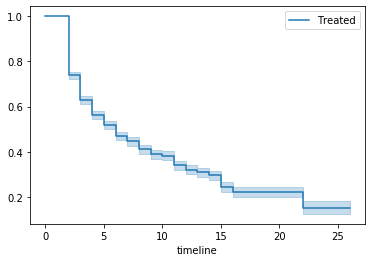

In [114]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
kmf = KaplanMeierFitter()
kmf.fit(duration_t, event_observed=events_t, label = 'Treated')  
ax = kmf.plot()
kmf2 = KaplanMeierFitter()
kmf2.fit(duration_c, event_observed=events_c, label = 'Control')  
kmf2.plot(ax = ax)
plt.show()